# Train Diffusion Model
### Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim

# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import conf

### Config
General

In [2]:
remote_kernel: bool = True

logging_level: int = logging.INFO
model_name: str = "diffusion_v10"
full_model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)
checkpoint_freq: int = 10 #0 for no checkpoint saving
training_data_name: str = "training_full_low_res"

device = "cuda" if torch.cuda.is_available() else "cpu"
restart_training: bool = True #If True and model already exists optimizer and lr_scheduler are reset
learning_rate: float = 5e-4 #Starting lr/first lr for Threshold Scheduler
epochs: int = 100
n_training_samples: int = 6000

logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Data Loading

In [3]:
file: ndarray = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))[:n_training_samples, ...]
data_loader = create_dataloader(Audio_Data(file), conf["model"].batch_size)
logger.info(f"Data loaded with shape: {file.shape}")

2025-03-19 08:19:56,026 - INFO - Data loaded with shape: (6000, 224, 416)


### Model Creation
U-Net

In [4]:
u_net = Conv_U_NET(in_channels=1,
                    time_embed_dim=conf["model"].time_embed_dim, 
                    n_starting_filters=conf["model"].n_starting_filters, 
                    n_downsamples=conf["model"].n_downsamples, 
                    activation=nn.SiLU(), 
                    device=device,
                    use_modulation=False
                ).to(device)

optimizer = optim.AdamW(u_net.parameters(), lr=learning_rate)
scheduler = Threshold_LR(optimizer, [1, 0.1, 0.09, 0.85, 0.08, 0.07], [learning_rate, 2e-4, 1e-4, 1e-5, 1e-6, 1e-7])
start_epoch: int = 0

if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["model"])
    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        scheduler.load_state_dict(model["scheduler"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-03-19 08:19:57,220 - INFO - Model diffusion_v10 loaded with 17288513 Parameters


Diffusion

In [5]:
diffusion = Diffusion(model=u_net, 
                        noise_steps=conf["model"].diffusion_timesteps, 
                        noise_schedule="linear", 
                        input_dim=[conf["model"].batch_size, 1, file.shape[-2], file.shape[-1]],
                        device=device
                    )

#diffusion.visualize_diffusion_steps(x=torch.Tensor(file[:1]), noise_schedule=noise_schedule, device=device, n_spectograms=5)

### Train

2025-03-19 08:19:57,465 - INFO - Training started on cuda
2025-03-19 08:23:05,012 - INFO - Epoch 001: Avg. Loss: 3.02234e-01 Remaining Time: 05h 09min 26s LR: 5.00000e-04
2025-03-19 08:26:11,148 - INFO - Epoch 002: Avg. Loss: 8.81132e-02 Remaining Time: 05h 05min 10s LR: 1.00000e-05
2025-03-19 08:29:18,198 - INFO - Epoch 003: Avg. Loss: 8.34178e-02 Remaining Time: 05h 02min 10s LR: 1.00000e-05
2025-03-19 08:32:23,320 - INFO - Epoch 004: Avg. Loss: 8.22466e-02 Remaining Time: 04h 58min 20s LR: 1.00000e-05
2025-03-19 08:35:24,190 - INFO - Epoch 005: Avg. Loss: 8.14173e-02 Remaining Time: 04h 53min 27s LR: 1.00000e-05
2025-03-19 08:38:22,701 - INFO - Epoch 006: Avg. Loss: 8.37873e-02 Remaining Time: 04h 48min 35s LR: 1.00000e-05
2025-03-19 08:41:19,400 - INFO - Epoch 007: Avg. Loss: 7.87256e-02 Remaining Time: 04h 43min 51s LR: 1.00000e-06
2025-03-19 08:44:15,114 - INFO - Epoch 008: Avg. Loss: 7.99344e-02 Remaining Time: 04h 39min 22s LR: 1.00000e-06
2025-03-19 08:47:17,823 - INFO - Epoch

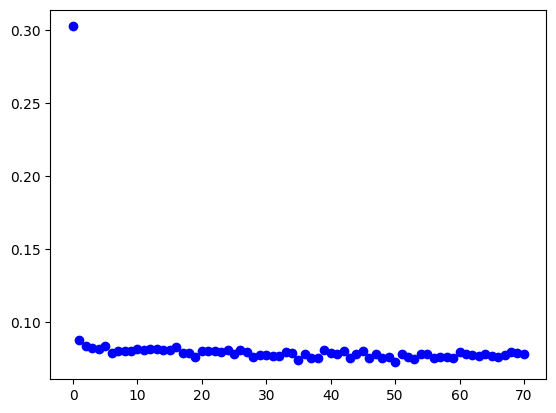

In [6]:
x = diffusion.train(epochs=epochs, 
                    data_loader=data_loader, 
                    loss_function=nn.MSELoss(),
                    optimizer=optimizer, 
                    lr_scheduler=scheduler, 
                    gradient_accum=conf["model"].gradient_accum,
                    checkpoint_freq=checkpoint_freq, 
                    model_path=full_model_path, 
                    start_epoch=start_epoch
                )
scatter_plot(x)